In [32]:
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Set random seed
np.random.seed(42)

In [33]:
def plot_gmm_density_matrix(n_samples, means, covs, weights, filename="gmm_density_plot.png"):
    """
    Generate a 3x3 matrix of density plots for a 3D Gaussian mixture.
    Each subplot has equal x and y limits and is visually square.
    """
    assert len(means) == len(covs) == len(weights), "Mismatch in number of components"

    # Sample from the mixture
    samples = np.vstack([
        np.random.multivariate_normal(mean, cov, int(w * n_samples))
        for mean, cov, w in zip(means, covs, weights)
    ])

    # Variable names and figure setup
    n_dim = len(means[0])
    dims = [f'X{d+1}' for d in range(n_dim)]
    fig, axes = plt.subplots(n_dim, n_dim, figsize=(12, 12))

    # Per-variable min/max limits
    limits = [(samples[:, d].min(), samples[:, d].max()) for d in range(n_dim)]

    for i in range(n_dim):
        for j in range(n_dim):
            ax = axes[i, j]

            if i == j:
                # Diagonal: marginal 1D distribution
                sns.histplot(samples[:, i], ax=ax, bins=30, color="skyblue", kde=False, stat="density")
                ax.set_ylabel("Density")
                ax.set_xlabel(dims[i])
                ax.set_xlim(limits[i])
            elif i > j:
                # Lower triangle: joint 2D density
                sns.scatterplot(
                    x=samples[:, j],
                    y=samples[:, i],
                    ax=ax,
                    s=10,                # point size
                    alpha=0.6,           # transparency
                    edgecolor=None       # cleaner dots
                )
                ax.set_xlabel(dims[j])
                ax.set_ylabel(dims[i])

                # Set axis limits to be equal
                shared_min = min(limits[i][0], limits[j][0])
                shared_max = max(limits[i][1], limits[j][1])
                ax.set_xlim(shared_min, shared_max)
                ax.set_ylim(shared_min, shared_max)

                # Set physical subplot to be square
                ax.set_aspect('equal', adjustable='box')
            else:
                ax.axis('off')  # Upper triangle: leave empty

    plt.tight_layout()
    plt.savefig(filename, dpi=100)
    plt.show()

In [3]:
np.linalg.det([[15, 5, 0], 
              [5, 5, 3], 
              [0, 3, 3]])

15.00000000000002

In [37]:
# Define GMM parameters
means = [np.array([-30, -0, -0]), np.array([-15, 0, 0]), np.array([0, -0, 0]), np.array([15, 0, 0]), np.array([30, -0, -0])]
weights = [0.3, 0.1, 0.2, 0.1, 0.3]
covs = [
    np.array([[5, 0, 0], 
              [0, 1, 1/5], 
              [0, 1/5, 1/5]]),
    np.array([[10, 0, 0], 
              [0, 1, 1/5], 
              [0, 1/5, 1/5]]),
    np.array([[5, 0, 0], 
              [0, 1, 1/5], 
              [0, 1/5, 1/5]]),
    np.array([[10, 0, 0], 
              [0, 1, 1/5], 
              [0, 1/5, 1/5]]),
    np.array([[5, 0, 0], 
              [0, 1, 1/5], 
              [0, 1/5, 1/5]])
]

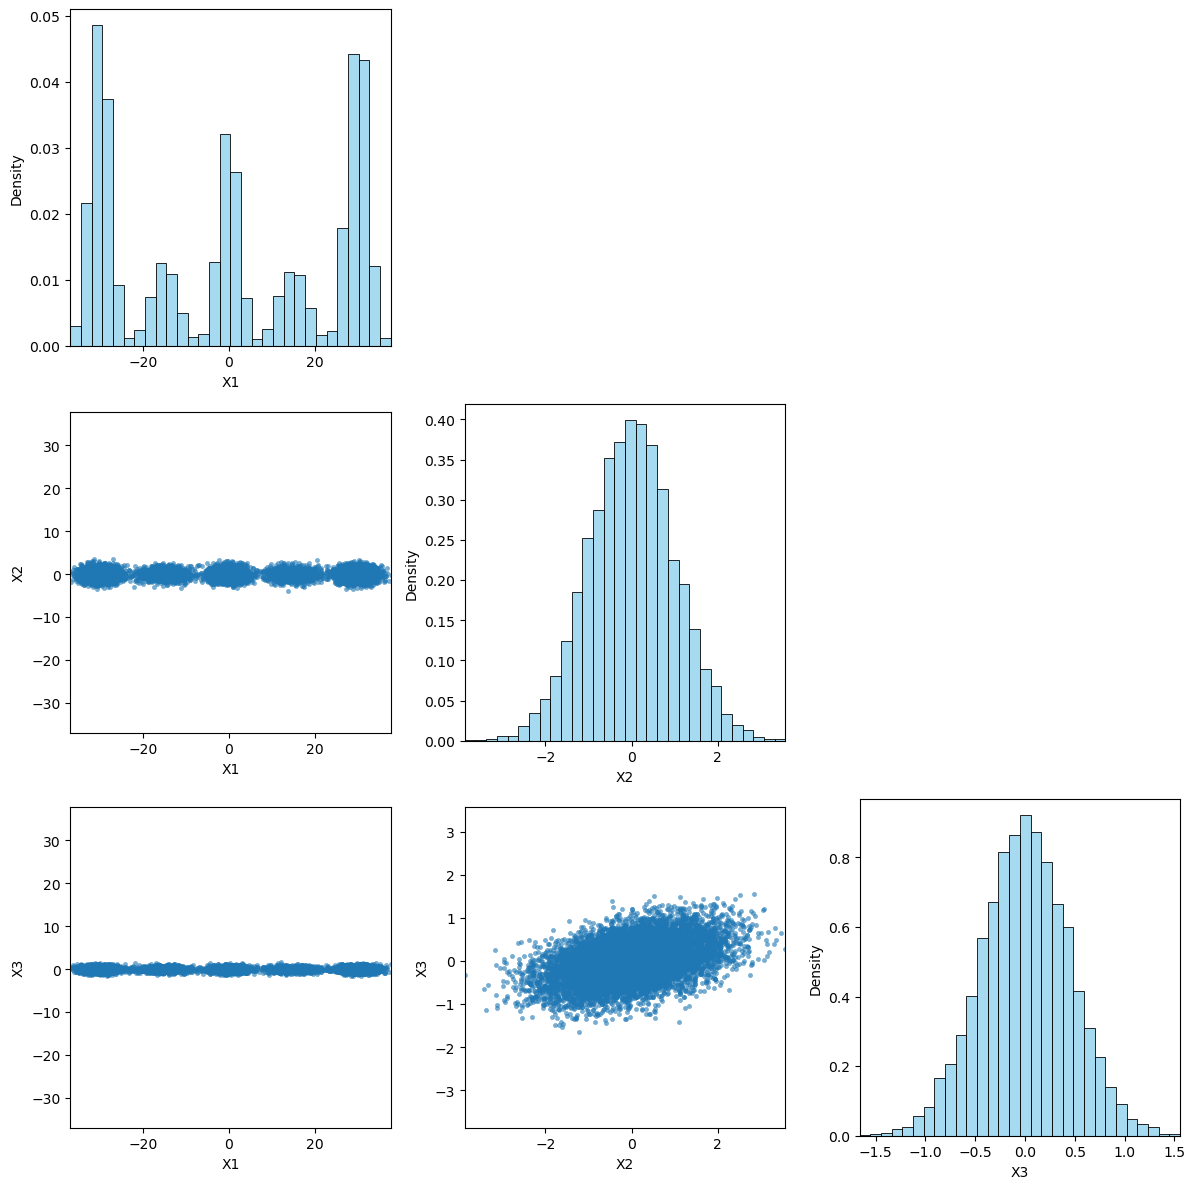

In [38]:
plot_gmm_density_matrix(n_samples=10000, means=means, covs=covs, weights=weights)

In [6]:
def score_log_gmm(x, means, weights, covs, inv_covs):
    K = len(means)
    D = len(x)
    scores = np.zeros((K, D))
    pdf_vals = np.zeros(K)

    for k in range(K):
        diff = x - means[k]
        inv_cov = inv_covs[k]
        pdf = multivariate_normal.pdf(x, mean=means[k], cov=covs[k])
        scores[k] = -inv_cov @ diff  # score of log N(x | mu_k, cov_k)
        pdf_vals[k] = weights[k] * pdf

    pi_x = np.sum(pdf_vals) + 1e-12
    weighted_scores = np.sum((pdf_vals[:, None] * scores), axis=0) / pi_x
    return weighted_scores  # ∇ log π(x)

def fisher_info_pi(means, weights, covs, n_samples=10000):
    D = len(means[0])
    inv_covs = [np.linalg.inv(cov) for cov in covs]
    K = len(means)

    samples = []
    for _ in range(n_samples):
        k = np.random.choice(K, p=weights)
        x = np.random.multivariate_normal(means[k], covs[k])
        samples.append(x)

    samples = np.array(samples)
    fisher = np.zeros((D, D))

    for x in samples:
        grad_log_pi = score_log_gmm(x, means, weights, covs, inv_covs)
        fisher += np.outer(grad_log_pi, grad_log_pi)

    fisher /= n_samples
    return fisher

In [7]:
fisher_pi = fisher_info_pi(means, weights, covs, n_samples=10000)
print("Fisher Information Matrix of π(x):\n", np.round(fisher_pi, 2))

Fisher Information Matrix of π(x):
 [[ 0.17  0.    0.  ]
 [ 0.    1.26 -1.22]
 [ 0.   -1.22  6.24]]


In [28]:
# Define GMM parameters
means = [np.array([-5, 0]), np.array([5, 0])]
weights = [0.5, 0.5]
covs = [
    np.array([[15, 0], [0, 1]]),
    np.array([[1, 0], [0, 15]])
]

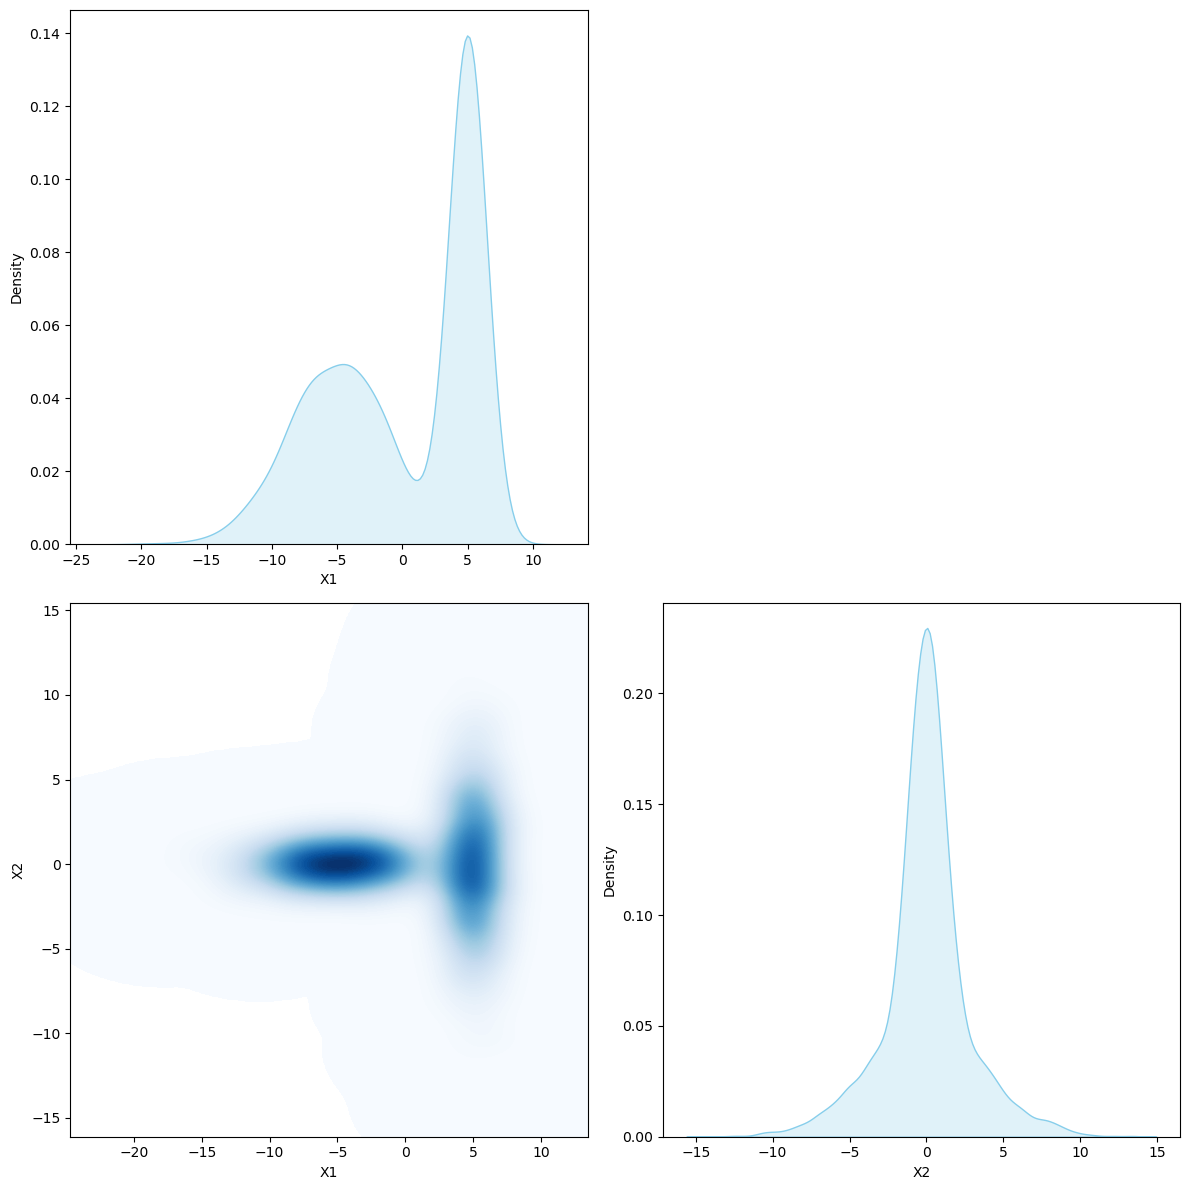

In [29]:
plot_gmm_density_matrix(n_samples=5000, means=means, covs=covs, weights=weights)

In [30]:
fisher_pi = fisher_info_pi(means, weights, covs, n_samples=10000)
print("Fisher Information Matrix of π(x):\n", np.round(fisher_pi, 2))
print(np.round(np.linalg.inv(fisher_pi), 2))

Fisher Information Matrix of π(x):
 [[0.49 0.  ]
 [0.   0.52]]
[[ 2.05 -0.02]
 [-0.02  1.92]]


In [46]:
# Define GMM parameters
means = [np.array([-15, 0]), np.array([15, 0])]
weights = [0.5, 0.5]
covs = [
    np.array([[15, 0], [0, 1]]),
    np.array([[15, 0], [0, 1]])
]

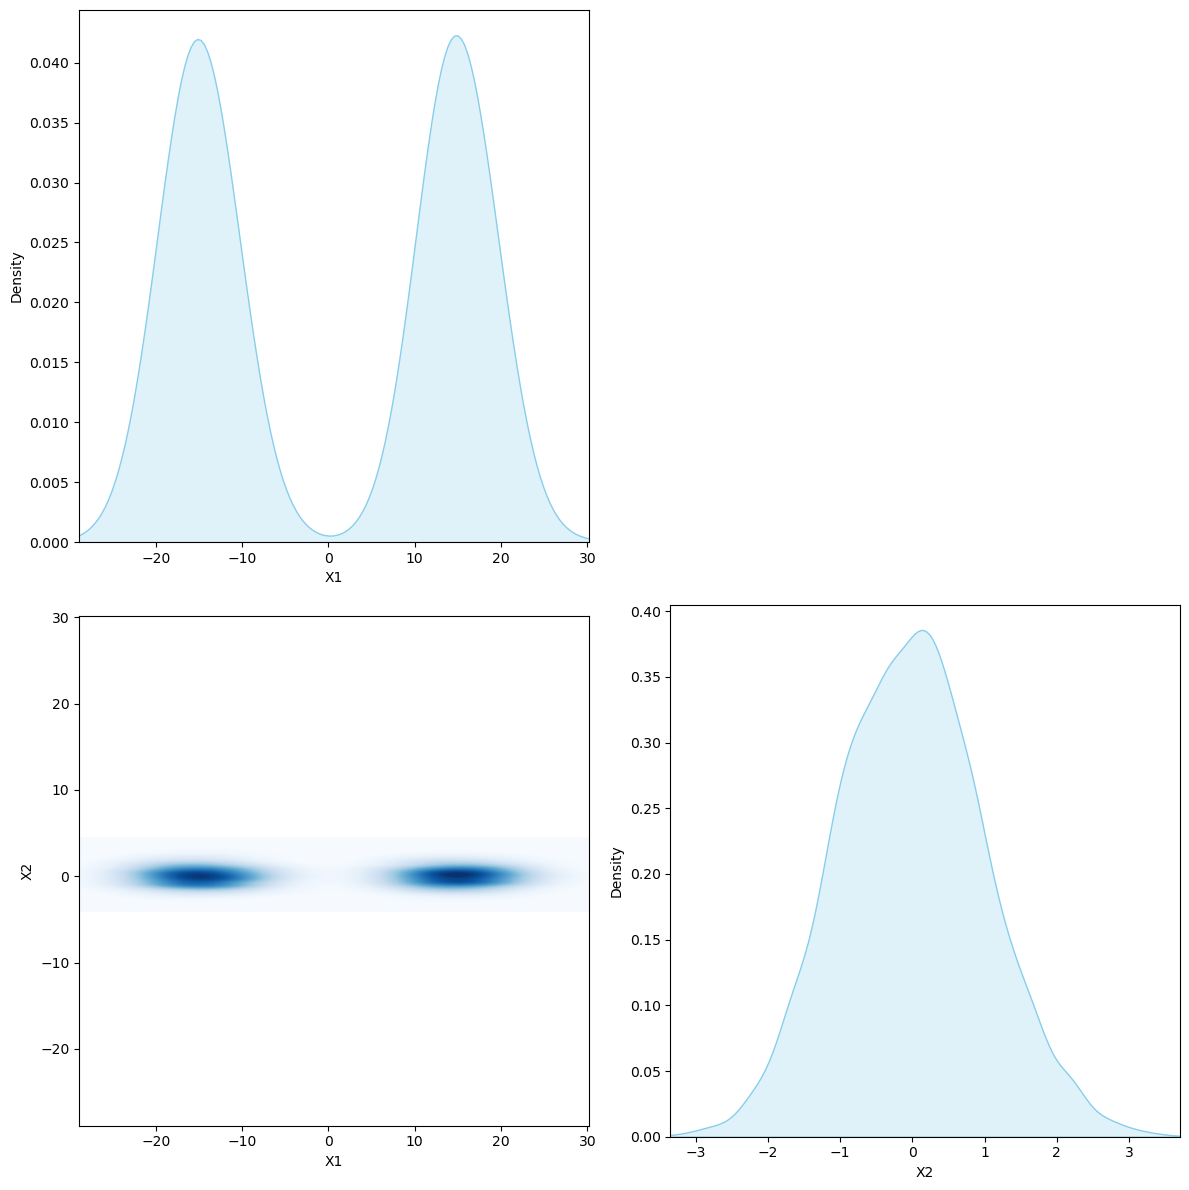

In [47]:
plot_gmm_density_matrix(n_samples=5000, means=means, covs=covs, weights=weights)

In [42]:
fisher_pi = fisher_info_pi(means, weights, covs, n_samples=10000)
print("Fisher Information Matrix of π(x):\n", np.round(fisher_pi, 2))
print(np.round(np.linalg.inv(fisher_pi), 2))

Fisher Information Matrix of π(x):
 [[0.07 0.  ]
 [0.   1.  ]]
[[ 1.478e+01 -1.000e-02]
 [-1.000e-02  1.000e+00]]


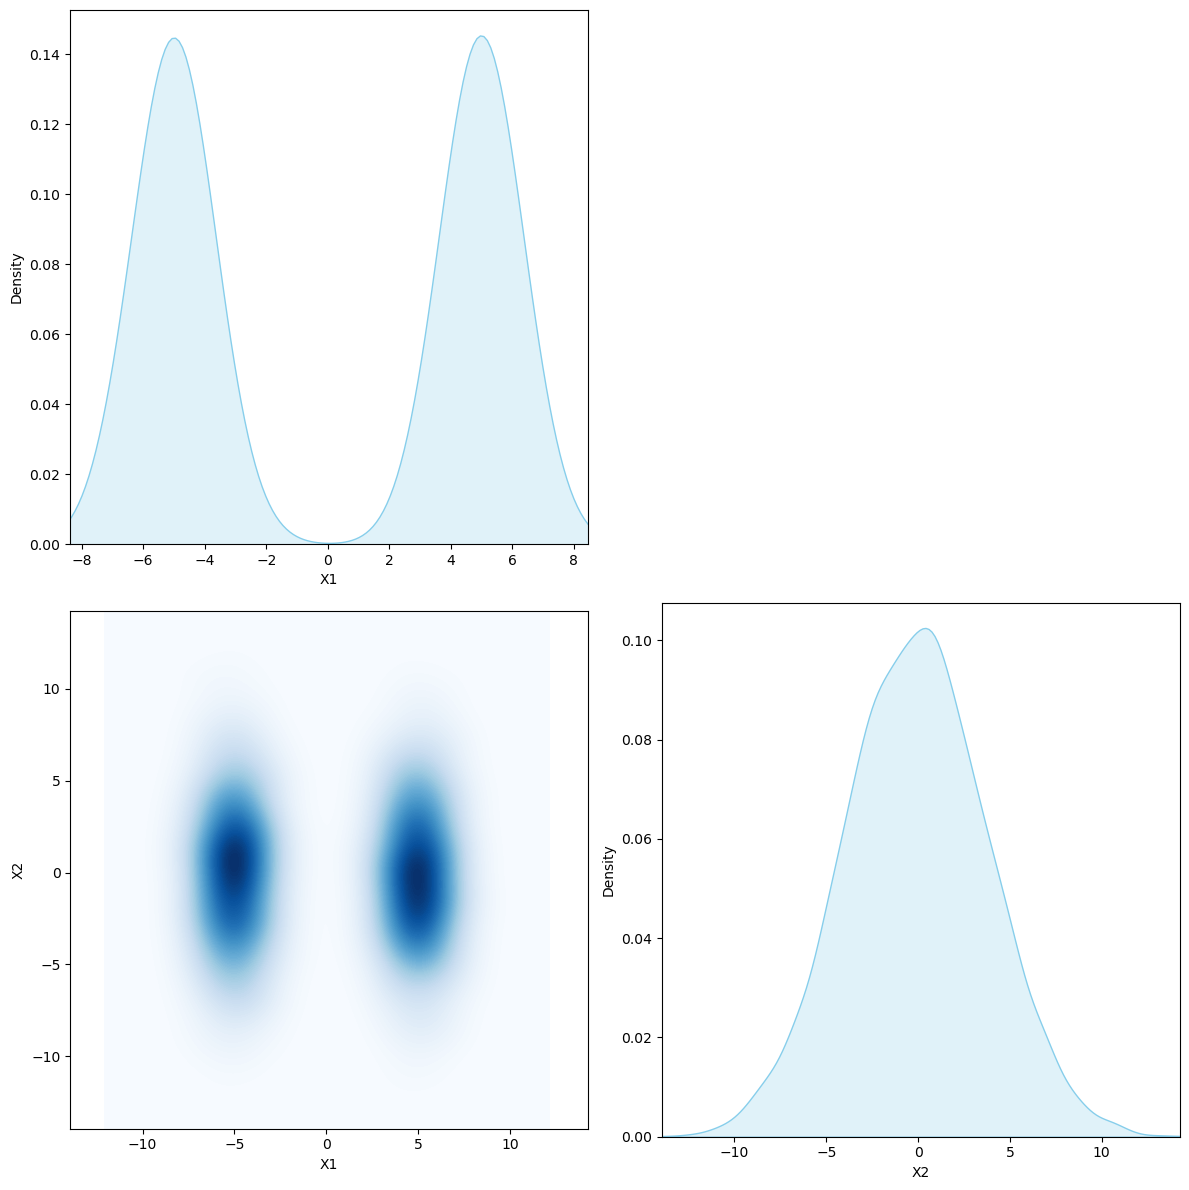

Fisher Information Matrix of π(x):
 [[1.01 0.  ]
 [0.   0.07]]
[[ 0.99 -0.05]
 [-0.05 14.66]]


In [44]:
# Define GMM parameters
means = [np.array([-5, 0]), np.array([5, 0])]
weights = [0.5, 0.5]
covs = [
    np.array([[1, 0], [0, 15]]),
    np.array([[1, 0], [0, 15]])
]
plot_gmm_density_matrix(n_samples=5000, means=means, covs=covs, weights=weights)
fisher_pi = fisher_info_pi(means, weights, covs, n_samples=10000)
print("Fisher Information Matrix of π(x):\n", np.round(fisher_pi, 2))
print(np.round(np.linalg.inv(fisher_pi), 2))